In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
import argparse
import os
import cv2
import matplotlib.image as mpimg

np.random.seed(0)


IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

In [3]:
model = Sequential()
model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE))
model.add(Conv2D(24, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(36, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(48, 5, 5, activation='elu', subsample=(2, 2)))
model.add(Conv2D(64, 3, 3, activation='elu'))
model.add(Conv2D(64, 3, 3, activation='elu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))
model.summary()

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  import sys


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)         0         
__________

In [4]:
data_dir = 'C:/Users/Dell/Desktop/Behavior-Cloning/sim_data/sim_data/data/'
PATH_TO_CSV = 'C:/Users/Dell/Desktop/Behavior-Cloning/sim_data/sim_data/data/driving_log.csv'
CORRECTION = 0.2

In [5]:
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)

In [6]:
def crop(image):
    """
    Crop the image (removing the sky at the top and the car front at the bottom)
    """
    return image[60:-25, :, :]  


def resize(image):
    """
    Resize the image to the input shape used by the network model
    
    """
    
    return cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)


def rgb2yuv(image):
    """
    Convert the image from RGB to YUV (as per the NVIDIA model )
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)


def preprocess(image):
    """
    Combine all preprocess functions into one
    """
    image = crop(image)
    image = resize(image)
    image = rgb2yuv(image)
    return image

In [7]:
def load_image(choice , data_dir, image_file ,steering_angle):
    """
    Load RGB images from a file
    """
    image = mpimg.imread(os.path.join(data_dir, image_file.strip()))
    
    image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)

    
    if(choice==0):
        plt.title('Left Image')
    elif(choice==1):
        plt.title('Right Image')
    elif(choice==2):
        plt.title('Center Image')
        
    plt.imshow(image)

    if(choice==0):
        adjusted_steer_angle = steering_angle.item() + 0.2
        plt.xlabel("Steering Angle :" + str(steering_angle) +"\n Steering Angle after correction:"+ str(adjusted_steer_angle))
    elif(choice==1):
        adjusted_steer_angle = steering_angle.item() - 0.2
        plt.xlabel("Steering Angle :" + str(steering_angle) +"\n Steering Angle after correction:"+ str(adjusted_steer_angle))
    elif(choice==2):
        adjusted_steer_angle = steering_angle.item()
        plt.xlabel("Steering Angle :" + str(steering_angle) +"\n Steering Angle after correction:"+ str(adjusted_steer_angle))

    return image

In [8]:
def load_data(data_dir,PATH_TO_CSV):
    """
    Load training data and split it into training and validation set
    """
    data_df = pd.read_csv(PATH_TO_CSV)

    X = data_df[['center', 'left', 'right']].values
    y = data_df['steering'].values

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

    return X_train, X_valid, y_train, y_valid


In [35]:
def choose_image(data_dir, center, left, right, steering_angle):
    """
    Randomly choose an image from the center, left or right, and adjust
    the steering angle.
    """
    choice = np.random.choice(3)
    if choice == 0:
        adjusted_angle = steering_angle.item() + 0.2
        image = load_image( choice ,data_dir, left ,steering_angle)
        return image , adjusted_angle,choice
    elif choice == 1:
        adjusted_angle = steering_angle.item() - 0.2
        image = load_image( choice ,data_dir, right ,steering_angle)
        return image , adjusted_angle,choice
    elif choice == 2:
        adjusted_angle = steering_angle.item()
        image = load_image( choice ,data_dir, center ,steering_angle)
        return image , adjusted_angle,choice
    
    #return image , adjusted_angle


def random_flip(image, steering_angle ,choice):
    """
    Randomly flipt the image left <-> right, and adjust the steering angle.
    """
    setflag = 1

    #if np.random.rand() < 0.5:
    if(setflag==1):
        image_flip = cv2.flip(image, 1)
        steering_angle_flip = -steering_angle
        f, (ax1,ax2) = plt.subplots(1, 2, figsize=(11,11))
        
        if choice == 0:
            ax1.set_title('Original Left Image')
        elif choice == 1:
            ax1.set_title('Original Right Image')
        elif choice == 2:
            ax1.set_title('Original Center Image')
        ax1.imshow(image)
        ax1.set_xlabel("Steering Angle:"+ str(steering_angle))
       
        if choice == 0:
            ax2.set_title('Flipped Left Image')
        elif choice == 1:
            ax2.set_title('Flipped Right Image')
        elif choice == 2:
            ax2.set_title('Flipped Center Image')
     
        ax2.imshow(image_flip)
        ax2.set_xlabel("Flipped Steering Angle:"+ str(steering_angle_flip))
        return image_flip, steering_angle_flip ,choice
        
    #return image_flip, steering_angle_flip , choice


def random_translate(image, steering_angle, range_x, range_y,choice):
    """
    Randomly shift the image virtially and horizontally (translation).
    """
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle_tr = steering_angle +  trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image_tr = cv2.warpAffine(image, trans_m, (width, height))
    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(11,11))
    if choice == 0:
        ax1.set_title('Flipped Left Image')
    elif choice == 1:
        ax1.set_title('Flipped Right Image')
    elif choice == 2:
        ax1.set_title('Flipped Center Image')
    
    ax1.imshow(image)
    ax1.set_xlabel("Steering Angle:"+ str(steering_angle))
    #ax2.set_title('Translated / Warped Image')
    if choice == 0:
        ax2.set_title('Translated / Warped Left Image')
    elif choice == 1:
        ax2.set_title('Translated / Warped Right Image')
    elif choice == 2:
        ax2.set_title('Translated / Warped Center Image')
    ax2.imshow(image_tr)
    ax2.set_xlabel("Steering Angle of Translated / Warped Image:"+ str(steering_angle_tr))
    
    
    return image_tr, steering_angle_tr,choice


def random_shadow(origimage,choice):
    """
    Generates and adds random shadow
    """
    # (x1, y1) and (x2, y2) forms a line
    # xm, ym gives all the locations of the image
    x1, y1 = IMAGE_WIDTH * np.random.rand(), 0
    x2, y2 = IMAGE_WIDTH * np.random.rand(), IMAGE_HEIGHT
    xm, ym = np.mgrid[0:IMAGE_HEIGHT, 0:IMAGE_WIDTH]
    
    """x1, y1 = image.shape[0] * np.random.rand(), 0
    x2, y2 = image.shape[0] * np.random.rand(), image.shape[1]
    xm, ym = np.mgrid[0:image.shape[1], 0:image.shape[0]]"""


    # mathematically speaking, we want to set 1 below the line and zero otherwise
    # Our coordinate is up side down.  So, the above the line: 
    # (ym-y1)/(xm-x1) > (y2-y1)/(x2-x1)
    # as x2 == x1 causes zero-division problem, we'll write it in the below form:
    # (ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0
    mask = np.zeros_like(origimage[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    # choose which side should have shadow and adjust saturation
    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.2, high=0.5)

    # adjust Saturation in HLS(Hue, Light, Saturation)
    hls = cv2.cvtColor(origimage, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    
    image_with_shadow = cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)
    
    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(11,11))
    #ax1.set_title('Original Image')
    if choice == 0:
        ax1.set_title('Translated / Warped Left Image')
    elif choice == 1:
        ax1.set_title('Translated / Warped Right Image')
    elif choice == 2:
        ax1.set_title('Translated / Warped Center Image')
    ax1.imshow(origimage)
   
    #ax2.set_title('Image with Shadows Generated')
    if choice == 0:
        ax2.set_title('Left Image with Shadows Generated')
    elif choice == 1:
        ax2.set_title('Right Image with Shadows Generated')
    elif choice == 2:
        ax2.set_title('Center Image with Shadows Generated')
    ax2.imshow(image_with_shadow)
  
    
    return image_with_shadow,choice


def random_brightness(image,choice):
    """
    Randomly adjust brightness of the image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    
    brightalter_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    
    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(11,11))
    
    if choice == 0:
        ax1.set_title('Shadowed Left Image')
    elif choice == 1:
        ax1.set_title('Shadowed Right Image')
    elif choice == 2:
        ax1.set_title('Shadowed Center Image')
    ax1.imshow(image)
    
    if choice == 0:
        ax2.set_title('Left Image with Brightness Altered')
    elif choice == 1:
        ax2.set_title('Right Image with Brightness Altered')
    elif choice == 2:
        ax2.set_title('Center Image with Brightness Altered')
    ax2.imshow(brightalter_img)
    
    
    return brightalter_img,choice

In [36]:
def augment(data_dir, center, left, right, steering_angle, range_x=100, range_y=10):
    """
    Generate an augmented image and adjust steering angle.
    (The steering angle is associated with the center image)
    """
    
    image, steering_angle ,choice = choose_image(data_dir, center, left, right, steering_angle )

    image, steering_angle ,choice = random_flip(image, steering_angle, choice)
    
    image, steering_angle , choice= random_translate(image, steering_angle, range_x, range_y ,choice)
   
    image,choice = random_shadow(image ,choice )
    image,choice = random_brightness(image,choice)
    return image, steering_angle

In [37]:
def batch_generator(data_dir, image_paths, steering_angles, batch_size, is_training):
   
   
    images = np.empty([batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    steers = np.empty(batch_size)
    
    i = 0
    
    for index in np.random.permutation(image_paths.shape[0]):
        if(i<1):
            
            center, left, right = image_paths[index]
         
            steering_angle = steering_angles[index]
            
            # augmentation
            image, steering_angle = augment(data_dir, center, left, right, steering_angle)
            #if(np.random.rand() < 0.6):
                #image, steering_angle = augment(data_dir, center, left, right, steering_angle)
        
                #images[i] = preprocess(image)
                #steers[i] = steering_angle
            #else:
                #image = load_image(data_dir, center) 
            # add the image and steering angle to the batch
            
            i += 1

    """while True:
       
        i = 0
        
        
        for index in np.random.permutation(image_paths.shape[0]):
            center, left, right = image_paths[index]
            print(center, left, right)
            steering_angle = steering_angles[index]
            print(steering_angle)
            # augmentation
            image, steering_angle = augment(data_dir, center, left, right, steering_angle)
            #if(np.random.rand() < 0.6):
                #image, steering_angle = augment(data_dir, center, left, right, steering_angle)
        
                #images[i] = preprocess(image)
                #steers[i] = steering_angle
            #else:
                #image = load_image(data_dir, center) 
            # add the image and steering angle to the batch
            
            i += 1
            #if i == batch_size:
            if i == 1:
                break
        #return images, steers"""

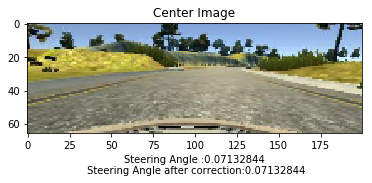

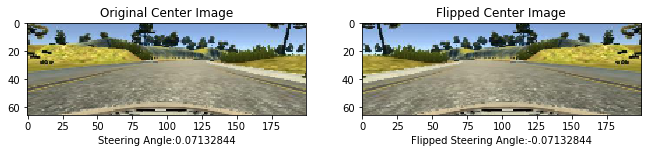

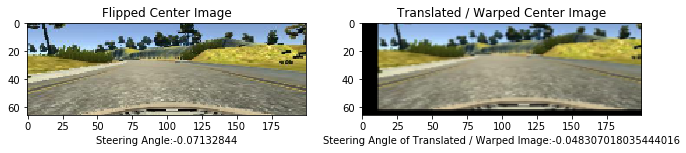

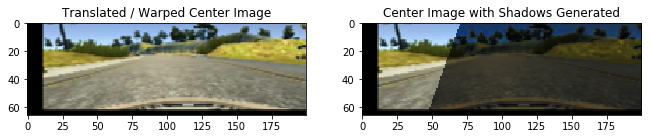

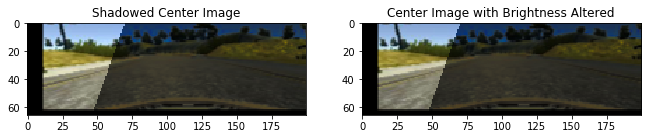

In [74]:
X_train, X_valid, y_train, y_valid = load_data(data_dir,PATH_TO_CSV)

batch_generator(data_dir, X_train, y_train, 40, False)